<h1 align="center">Round 4.1 - TensorFlow Input Pipeline</h1>

This notebook is a part of teaching material for CS-EJ3311 - Deep Learning with Python 13.09.-17.12.2021

Aalto University (Espoo, Finland)\
fitech.io (Finland)

Those who are familiar with `scikit-learn` Python package, will remember that most machine learning (ML) methods provided by the package have the same usage pattern. First, we load the training data into numpy arrays that store the features and labels of all training data points. These numpy arrays are then fed to `.fit()` function that implements the learning algorithm for a particular ML model. After the model has been trained, we apply it to the new data points, using `.predict()` function, in order to obtain predictions for the labels of new data points. 

In contrast, deep learning often involve extremely large training data sets which cannot be stored entirely in a numpy array (we would run out of RAM on a desktop computer). Therefore, deep learning methods use sequential access to training data. This approach ties in nicely with the working principle of stochastic gradient descent (SGD). In particular, we divide the dataset into smaller sets or parts called **batches** and only store a single batch in the working memory (e.g. as numpy arrays). The total number of samples present in a single batch is called **batch size**. 

After loading a new batch of data, we update the ANN parameters (weights and bias) using one iteration of an SGD variant. We repeat this batch-wise optimization until we have read each data point of the dataset. A sequence of batches that together cover the entire dataset is called an **epoch**. Note that the batch size is a hyperparameter of the resulting deep learning method. The choice of hyperparameter is often based on manual tuning ("trial and error") to minimize the validation loss. 

In previous rounds we focused on deep learning models and optimizers. While model architecture and optimization algorithm are determining factors for overall performance, there is one more factor that can create a performance bottleneck: input pipeline. Opening, reading and preprocessing data consume significant amount of time and resources.

The need for efficient input pipelines coincide with increased availability of GPU and TPU hardware accelerators. GPU and TPU are optimized for computations with vectors and matrices, but they are not handling data transformation and preprocessing well. Therefore, data preprocessing is often performed on CPU, which limits efficient use of GPU and TPU. Inefficient use of accelerators in its turn increases financial burden as cost of GPU and TPU use is high, not mentioning an ecological footprint from training large deep neural networks.

In previous rounds we trained our model as follows:

- Opening a file if it hasn't been opened yet
- Fetching a data entry from the file
- Using the data for training

In this scenario, the process is sequential: model is sitting idle, while data is read and fetching is stall during training:

<img src="../../../coursedata/R4/naive.png">

**tf.data** is a framework for building and executing efficient input pipelines for deep learning. The idea of tf.data input pipeline is to decouple data delivery and data consumption steps, thus decreasing time spent in idle state. This is achieved with introducing prefetching of data: while model is training on the current samples, the input pipeline prepares data samples for the next training step. This result in overlapping preprocessing with model training computations. 

<img src="../../../coursedata/R4/prefetch.png"/>


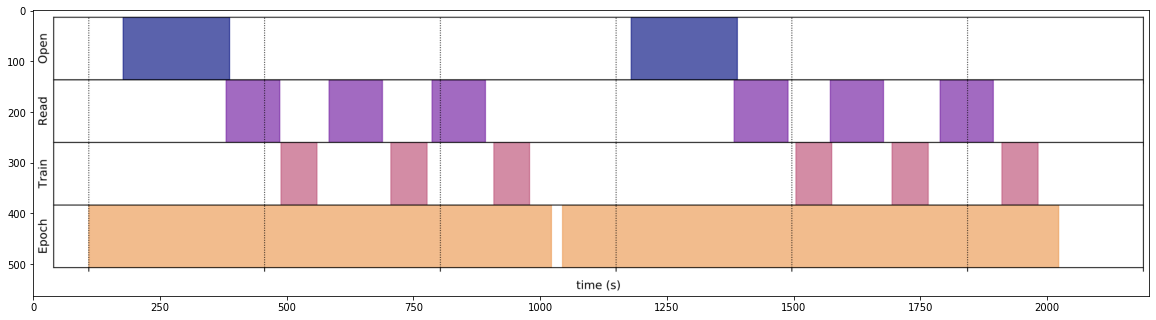

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
MSELinPred_image_naive = plt.imread("../../../coursedata/R4/naive.png")
plt.imshow(MSELinPred_image_naive)

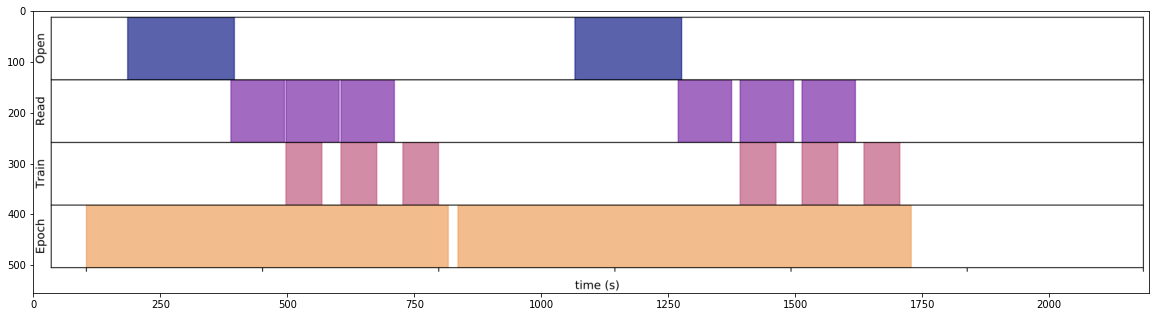

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
MSELinPred_image_prefetch = plt.imread("../../../coursedata/R4/prefetch.png")
plt.imshow(MSELinPred_image_prefetch)

[Tensorflow documentation](https://www.tensorflow.org/guide/data_performance#prefetching) states: 

<div class="blockquote-container">
    <blockquote class="ludwig">
        The tf.data API provides the tf.data.Dataset.prefetch transformation. It can 
        be used to decouple the time when data is produced from the time when data is 
        consumed. In particular, the transformation uses a background thread and an 
        internal buffer to prefetch elements from the input dataset ahead of the time 
        they are requested. The number of elements to prefetch should be equal to (or 
        possibly greater than) the number of batches consumed by a single training 
        step. You could either manually tune this value, or set it to 
        tf.data.AUTOTUNE, which will prompt the tf.data runtime to tune the value 
        dynamically at runtime.
    </blockquote>
</div>

**tf.data.AUTOTUNE** allows automatically tune parameters such as the degree of parallelism and data prefetch buffer sizes, which are critical for performance, yet often challenging for an average ML user to tune by hand.

tf.data API also provides solution for [efficient data extraction](https://www.tensorflow.org/guide/data_performance#parallelizing_data_extraction) from remote storage and for [parallelizing data transformation](https://www.tensorflow.org/guide/data_performance#parallelizing_data_transformation).

## Learning goals

- understand the motivation behind building input pipelines. 
- understand the basic idea of tf.data API. 
- be able to build simple tf.data.Dataset and apply various transformations.  

## Recommended Reading

-   tensorflow guide: ["tf.data: Build TensorFlow input pipelines"](https://www.tensorflow.org/guide/data#randomly_shuffling_input_data)
- tensorflow guide: ["Better performance with the tf.data API"](https://www.tensorflow.org/guide/data_performance#parallelizing_data_transformation)
- original paper [tf.data: A Machine Learning Data Processing Framework](https://arxiv.org/pdf/2101.12127.pdf)

tf.data API is based on ETL principle - **Extract, Transform, Load**.\
Data can be of different format: csv & txt files, numpy arrays, images. Various transformation can be applied to tf.data.Dataset, see list [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#methods_2).

<img src="../../../coursedata/R4/tf.data.png"/>
<center>
    <a href="https://www.kaggle.com/jalammar/intro-to-data-input-pipelines-with-tf-data">modified from</a>    
</center>

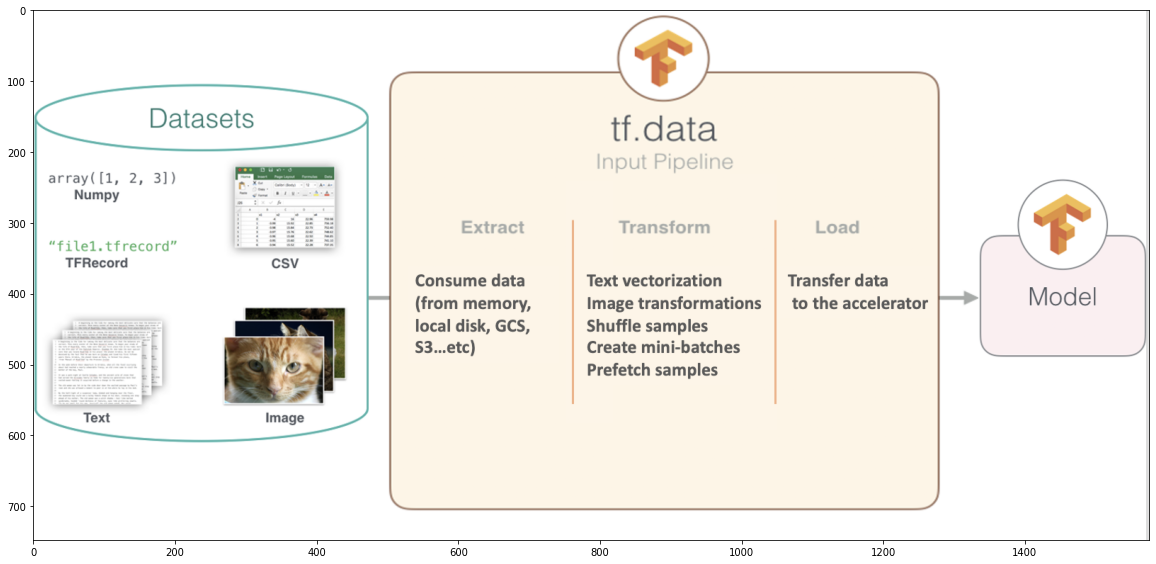

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
MSELinPred_image_prefetch = plt.imread("../../../coursedata/R4/tf.data.png")
plt.imshow(MSELinPred_image_prefetch)

Here is a video where creators discuss motivation and basic ideas of tf.data pipelines:
https://www.youtube.com/watch?v=VeV65oVvoes

tf.data API introduces a tf.data.Dataset abstraction for users to define their input pipeline. Internally tf.data represents an input pipeline dataset as a graph. Let's create our first tf.data.Dataset object from list of numbers:

<div class=" alert alert-info">
    <h3><b>Demo.</b>  tf.data.Dataset object from list.</h3>
        

     
</div>

First step is to extract data. We use `tf.data.Dataset.from_tensor_slices()` expression for lists and tensors to create an instance of tf.data.Dataset object:

In [1]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

We can use dataset as an iterator and iterate samples in for-loop:

In [8]:
for value in dataset:
    print(value)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


As you can see, the returned values are tensorflow tensors. We can easily convert them into numpy object:

In [9]:
for value in dataset:
    print(value.numpy())

1
2
3
4
5
6


We can apply various transformations to each sample by chaining functions provided by tf.data. For example:

- repeat dataset n-times
- apply custom function, e.g. which returns square of a value
- shuffle samples 
- create mini-batches
- prefetch samples

"New" dataset can be generated from the original by repeating samples with `.repeat()` transformation:

In [10]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.repeat(2) # repeat tensor 2 times

for value in dataset:
    print(value.numpy()) # print values as type numpy.int32 and not tf.Tensor

1
2
3
1
2
3


To apply custom preprocessing function we write usual Python function and pass this function as an argument to `dataset.map(map_func)`:

In [15]:
# user defined function
def preprocess(x):
    return x*x

dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.map(preprocess) # apply custom function `preprocess` to data

for value in dataset:
    print(value.numpy()) 

1
4
9


As input samples are independent, tf.data.Dataset.map transformation allows to parallelize it across multiple CPU cores. The map transformation provides the `num_parallel_calls` argument to specify the level of parallelism.

[Tensorflow guide](https://www.tensorflow.org/guide/data_performance#parallelizing_data_transformation): 

<div class="blockquote-container">
    <blockquote class="ludwig">
Choosing the best value for the num_parallel_calls argument depends on hardware, characteristics of your training data (such as its size and shape), the cost of your map function, and what other processing is happening on the CPU at the same time. A simple heuristic is to use the number of available CPU cores. However, as for the prefetch and interleave transformation, the map transformation supports tf.data.AUTOTUNE which will delegate the decision about what level of parallelism to use to the tf.data runtime.
    </blockquote>
</div>

Although in our simple example the effect of parallelism is negligible, in general it is advisable to set argument `num_parallel_calls=AUTOTUNE` for `.map()` function:

In [16]:
# set AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE) # number of parallel calls will be set by AUTOTUNE

for value in dataset:
    print(value.numpy()) 

1
4
9


To shuffle samples we call `dataset.shuffle(buffer_size)`. The `dataset.shuffle()` transformation maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer. See [here](https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset) explained example of buffer size for shuffle function. In short, buffer size will affect randomness of a batch, thus it should be at least few times larger than batch size.


Batches are formed with `dataset.batch(batch_size)`. As was discussed previously batch size should not exceed memory limits of CPU used.

Finally, we can prefetch samples with `dataset.prefetch(buffer_size)`. From [tensorflow docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch): 

<div class="blockquote-container">
    <blockquote class="ludwig">
Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.
    </blockquote>   
</div>
   
        
Here, buffer size indicates number of elements to prefetch. For example, `dataset.batch(20).prefetch(2)` will prefetch 2 elements (2 batches, of 20 examples each). Similarly to `.map()` transformation, we can set buffer size to AUTOTUNE in `prefetch()` for automatic estimation of buffer size.

You can read discussion about difference of buffer size parameter for these functions [here](https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle).

Let's chain all transformations and call `dataset.take()` to create batches of samples:

In [17]:
import numpy as np

In [18]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))

dataset = dataset.repeat(100)
dataset = dataset.map(preprocess)
dataset = dataset.shuffle(buffer_size=20, seed=42)
dataset = dataset.batch(batch_size=5)
dataset = dataset.prefetch(buffer_size=2)

for count_batch in dataset.take(3):
    print(count_batch.numpy())

[25  4 64  1 49]
[81  4  0  0 16]
[36  1  9  0 81]


or, shorter:

In [19]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))

dataset = dataset.repeat(100).map(preprocess).shuffle(20,seed=42).batch(5).prefetch(2)


for count_batch in dataset.take(3):
    print(count_batch.numpy())

[25  4 64  1 49]
[81  4  0  0 16]
[36  1  9  0 81]


<div class=" alert alert-success">
       <center> <h3>Python Generators.</h3></center>
</div>   

In this round we discuss data generators for deep learning. What are the Python generators in general? Python generator is a function which behaves like an iterator, i.e. it can be used in a for-loop. It looks like a normal function except that it contains `yield` expression (instead of `return`) for producing a series of values usable in a for-loop or that can be retrieved one at a time with the `next()` function link. 
Look at the example of a simple Python generator function, which generates infinite sequence of numbers:

In [20]:
# define a Python generator function, which can create an infinite sequence of numbers
def sequence_generator():   
    number = 0
    while True:
        # `yield` statement pauses the function, saves all its states
        # and later continues from there on successive calls
        yield number
        number += 1

numbers = []
for number in sequence_generator():
    numbers.append(number)
    if number>9: # include `break` statement, otherwise the for-loop will iterate infinitely
        break
        
numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

We can access generated values of Python generator by using `next()` function:

In [21]:
# create generator object
a = sequence_generator()
# display the type of an object 
print("The variable `a` is ", type(a))

# display values generated by generator object by using function `next()`
next(a), next(a), next(a)

The variable `a` is  <class 'generator'>


(0, 1, 2)

<div class=" alert alert-warning">
    <h3><b>STUDENT TASK. </b>   tf.data.Dataset object from Python generator.</h3>
        
In this task you will build tf.data.Dataset object from Python generator.\
Use `tf.data.Dataset.from_generator()` constructor to convert the python generator to a fully functional tf.data.Dataset. Pass python generator `sequence_generator()` to the constructor and set `output_types` argument to tf.int32. See examples in [tensorflow tutorial](https://www.tensorflow.org/guide/data#consuming_python_generators).
    
After creating tf.data.Dataset object apply following transformations:
    
- use `preprocess` function to square all generator values. Set `num_parallel_calls` arg to `AUTOTUNE`.
- shuffle samples. Set `buffer_size` to 20 and `seed` arg to 42.
- create batches of size 5
- prefetch batches. Set `buffer_size` arg to `AUTOTUNE`.

</div>

In [22]:
# YOUR CODE HERE
#raise NotImplementedError()

# create tf.data.Dataset from python generator:

try:
    AUTOTUNE = tf.data.AUTOTUNE     
except:
    AUTOTUNE = tf.data.experimental.AUTOTUNE

ds_numbers = tf.data.Dataset.from_generator(sequence_generator, output_types=tf.int32)

# transformations:

ds_numbers = ds_numbers.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_numbers = ds_numbers.shuffle(buffer_size=20, seed=42)
ds_numbers = ds_numbers.batch(batch_size=5)
ds_numbers = ds_numbers.prefetch(buffer_size=tf.data.AUTOTUNE)

# retrieve first batch with as_numpy_iterator() & next() functions
first_batch = list(ds_numbers.as_numpy_iterator().next())
first_batch

[25, 144, 324, 121, 289]

In [23]:
# retrieve batches with a for-loop

i=1
for count_batch in ds_numbers.take(3):
    print("batch", i, count_batch.numpy())
    i+=1

batch 1 [  9 400   4 225  64]
batch 2 [ 16  25 256 289 324]
batch 3 [441  81 900 784  36]


In [24]:
# Sanity check

assert len(first_batch)==5, "Batch size should be 5!"
assert isinstance(first_batch[0], np.int32), "Set output_types to tf.int32!"
assert first_batch[0]==25, "First value of `fisrt_batch` list should be 25"

In [25]:
# this is hidden cell 


<div class=" alert alert-info">
    <h3><b>Demo.</b>tf.data.Dataset object from text file.</h3>    
</div>

Below we create generator for text data. 

We use `tf.data.TextLineDataset(filenames)` function that creates a Dataset consisting of lines from one or more text files.

In [26]:
file_path = '../../../coursedata/R4/poem.txt'
# create dataset from txt file
dataset = tf.data.TextLineDataset(file_path)

# print samples from dataset
for line in dataset.take(5):
    print(line.numpy())

b'Once upon a midnight dreary, while I pondered, weak and weary,'
b'Over many a quaint and curious volume of forgotten lore-'
b'While I nodded, nearly napping, suddenly there came a tapping,'
b'As of some one gently rapping, rapping at my chamber door.'
b'"\'Tis some visitor," I muttered, "tapping at my chamber door-'


Similar to numbers and tensors, we can shuffle samples (text lines in this case) and form batches:

In [27]:
dataset = tf.data.TextLineDataset(file_path)

for line in dataset.shuffle(20).batch(5).take(2):
    print("\nbatch:\n", line.numpy())


batch:
 [b'Presently my soul grew stronger; hesitating then no longer,'
 b'From my books surcease of sorrow-sorrow for the lost Lenore-'
 b'Ah, distinctly I remember it was in the bleak December;'
 b'"Sir," said I, "or Madam, truly your forgiveness I implore;'
 b'Only this and nothing more."']

batch:
 [b'And so faintly you came tapping, tapping at my chamber door,'
 b'For the rare and radiant maiden whom the angels name Lenore-'
 b'Eagerly I wished the morrow;-vainly I had sought to borrow'
 b'Deep into that darkness peering, long I stood there wondering, fearing,'
 b'Darkness there and nothing more.']


<div class=" alert alert-info">
    <h3><b>Demo. </b>Generators with tf.data.Dataset.</h3>
        
In this demo, we build data generator with tf.data API for a subset of ["Cats vs Dogs"](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset. This dataset is in the form of images that belong to two different classes "cats" and "dogs". Binary label is assigned to each image and can take values either 1 for cat image or 0 for dog image. 

The images (data points) are stored in the "cats_and_dogs_small" directory (in coursedata folder). The main directory contains three subdirectories: 'train', 'test', and 'validation'. These three directories contain, respectively, the training, validation, and test images. The images in these three directories are stored in two subdirectories named "cats" and "dogs", which contain images belonging to corresponding class labels.
     
</div>

In [28]:
import os    # library to interact with operating system
import pathlib    # library to perform filesystem interactions
import matplotlib.pyplot as plt    # library for generating plots

<div class=" alert alert-success">
       <center> <h3>Handling paths with pathlib library.</h3></center>
</div>   

Images are stored in 'cats_and_dogs_small' folder and the path to it is '../../../coursedata/cats_and_dogs_small'. Instead of defining path as a string, we will use Python pathlib library to define path to data:

In [29]:
# The path to the dataset
base_dir = pathlib.Path.cwd() / '..' / '..' /  '..' / 'coursedata' / 'cats_and_dogs_small'
base_dir

PosixPath('/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small')

`pathlib.Path.cwd()` function gives a reference to the current directory (the directory in which this notebook is stored): 

In [30]:
pathlib.Path.cwd()

PosixPath('/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization')

Using the operator `/` we concatenate the rest of the path to the collection. Notice that `/` is an operator and not a string. It is a convenient syntax to concatenate parts of a path. But, why cannot we just use a string containing the actual path? The answer is portability. The Jupyter Hub may be running in a Linux environment, but your laptop may be running Windows. If you want to use the same code in both operating systems, then you must use the operator `/` to construct the paths. For a more detailed explanation of `pathlib` consult [Python 3's pathlib Module: Taming the File System](https://realpython.com/python-pathlib/).

Notice, that `base_dir` is not a string - it is a PosixPath object. PosixPath object has plenty of attributes and methods ( you can check full list with `dir(base_dir)` or `help(base_dir)`). For example, method  `.glob()` is used to list all files (or sub-directories) in a directory:

In [31]:
print(type(base_dir.glob('*')))

for file in base_dir.glob('*'):
    print(file)

<class 'generator'>
/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small/train
/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small/validation
/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small/test


You can see, that it returns a generator object, that can be used to list files or subdirectories. Input argument of `glob()` is called pattern, and used to select files of a certain type. For example, pattern '$*$' returns all files and '$*$.txt' will return only text files:

In [32]:
temp_dir = pathlib.Path.cwd()

# select only jupyter notebooks
for file in temp_dir.glob('*.ipynb'):
    print(file)

/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/Round4.1_TensorFlowData.ipynb
/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/Round4.2_DataAugmentation.ipynb
/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/Round4.3_TransferLearning.ipynb


We can count how many images there are in total by using `glob()` function:

In [33]:
# count jpg files in all subdirectories of data_dir
image_count = len(list(base_dir.glob('*/*/*.jpg')))
print(f'Total number of images in the dataset: {image_count}')

Total number of images in the dataset: 3992


Now we can create the datasets. We use the function [tf.data.Dataset.list_files](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files). This function expects a `file_pattern` which can be a string or a list of strings representing the filename wildcard. "Cats and Dogs" dataset consist of images, which we can retrieve with `*.jpg` wildcard. For example, to get paths of images in train folder we use `train/*/*.jpg`. Notice, that with `*` symbol after `train/`  we indicate, that JPG images from all subdirectories of `train/` should be listed.

In [34]:
# create tf.data.Dataset objects from training, validation and test images
# use .list_files(file_pattern) function to select files that end with .jpg in each directory

train_ds = tf.data.Dataset.list_files(str(base_dir/'train/*/*.jpg'), shuffle=False)
val_ds   = tf.data.Dataset.list_files(str(base_dir/'validation/*/*.jpg'), shuffle=False)
test_ds  = tf.data.Dataset.list_files(str(base_dir/'test/*/*.jpg'), shuffle=False)

for file in train_ds.take(5):
    print(file.numpy())

b'/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small/train/cats/cat.0.jpg'
b'/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small/train/cats/cat.1.jpg'
b'/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small/train/cats/cat.10.jpg'
b'/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small/train/cats/cat.100.jpg'
b'/home/laptop/UNIVERSITY/CS-EJ3311/Deep-Learning-with-Python/Regularization/../../../coursedata/cats_and_dogs_small/train/cats/cat.101.jpg'


In [35]:
print(f'Number of images in the training set:\t {tf.data.experimental.cardinality(train_ds).numpy()}')
print(f'Number of images in the validation set:\t {tf.data.experimental.cardinality(val_ds).numpy()}')
print(f'Number of images in the test set:\t {tf.data.experimental.cardinality(test_ds).numpy()}')

Number of images in the training set:	 1997
Number of images in the validation set:	 995
Number of images in the test set:	 1000


Now, we have created `tf.data.Dataset` which "contains" path for images. In order to actually load images and transform to tensorflow arrays, we need to write custom image loader.\
We use `tf.io.read_file` function to read file and `tf.io.decode_jpeg`to decode a JPEG-encoded image to a uint8 tensor.\
We resize image with `tf.image.resize` which results in resized image encoded as float32 tensor. Finally, we scale tensor to get values in range [0,1]. 

In addition, we need to assign a label to each loaded and transformed image. We can get class names ("cats" or "dogs") from file path. For example, we can split path, e.g. `/coursedata/cats_and_dogs_small/train/cats/cat.101.jpg`, by path separator `/` and only select part `cats`, which is a class name.\
To split path we use `tf.strings.split(image_path, os.path.sep)`, which will return array of type:

```python
<tf.Tensor: shape=(15,), dtype=string, numpy=
array([b'', b'Users', b'shamsi', b'Desktop', b'dlpython', b'source', b'Round4', b'..', b'..', b'..', b'coursedata', b'cats_and_dogs_small', b'train', b'cats', b'cat.0.jpg'], dtype=object)>
```
Class name is at second to last position and we can select it with index [-2]. For example, `tf.strings.split(temp, os.path.sep)[-2]` will result in:

```python
<tf.Tensor: shape=(), dtype=string, numpy=b'cats'>
```

We can compare retrieved class name with list of class names `tf.strings.split(temp, os.path.sep)[-2] == ['cats', 'dogs']` and get boolean array:

```python
<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True, False])>
```

Finally, image label can be transformed to integer with `tf.argmax([True, False])`:

```python
<tf.Tensor: shape=(), dtype=int64, numpy=0>
```

In [36]:
CLASS_NAMES = ['cats', 'dogs']
IMG_SIZE = 150

def load_image(image_path):
    # load image
    image = tf.io.read_file(image_path)    # read the image from disk
    image = tf.io.decode_jpeg(image, channels=3)    # decode jpeg  
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])    # resize
    image = (image / 255)    # scale 
    
    # get lable value from path
    parts = tf.strings.split(image_path, os.path.sep)    # parse the class label from the file path
    one_hot = parts[-2] == CLASS_NAMES    # select only part with class name and create boolean array
    label = tf.argmax(one_hot)    # get label as integer from boolean array
    
    return (image, label)

To  apply the function `load_image` to each file in the datasets, we use the function [tf.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map). The first argument `map_func` defines the transformation applied to each element in the dataset. The `map` function returns a new tf.Dataset containing the transformed elements, in the same order as they appeared in the input. The second parameter `num_parallel_calls` represents the number of elements to process asynchronously in parallel.  If the value `tf.data.AUTOTUNE` is used, then the number of parallel calls is set dynamically based on the available CPU.

In [37]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(load_image, num_parallel_calls=AUTOTUNE)

You may be surprised that the execution of the cell is almost instantaneously. This is because the `map` function is a "lazy" transformation, which means that the processing only occurs when you try to consume the dataset. Our final step for creating the tf.Dataset is to configure them to performance:

* `shuffle()`: Randomly shuffles the elements of this dataset.
* `batch()`: Combines consecutive elements of this dataset into batches.
* `prefetch()`: Creates a Dataset that prefetches elements from this dataset. This allows later elements to be prepared while the current element is being processed. 

In [38]:
def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=2000)
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds   = configure_for_performance(val_ds)
test_ds  = configure_for_performance(test_ds)

Now we can retrieve one batch (features and labels) and display images:

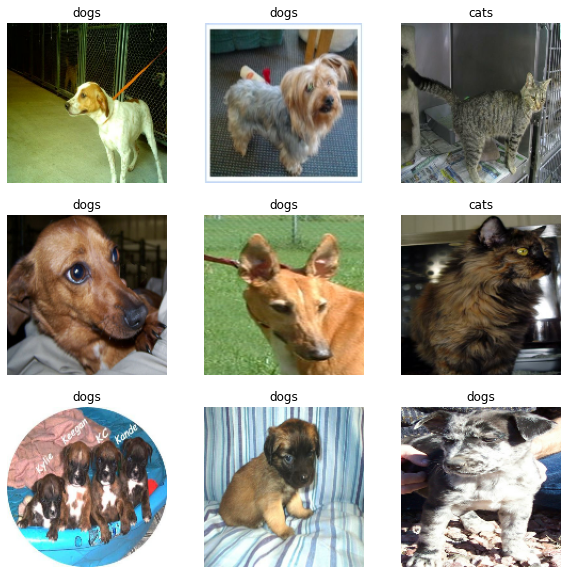

In [23]:
image_batch, label_batch = train_ds.as_numpy_iterator().next()

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(CLASS_NAMES[label])
    plt.axis("off")
    
plt.show()